# **Feature Extraction Notebook**

This notebook demonstrates two main feature extraction approaches for movie posters:

1. **Classic Feature Extraction** using HSV color histograms and Histogram of Oriented Gradients (HOG).
2. **Advanced Feature Extraction** leveraging deep learning models including a fine-tuned ResNet50, Vision Transformers (ViT), and a custom CNN architecture.

The extracted features are saved to disk for further use in movie genre classification tasks.

## **Section 1: Classic Feature Extraction**

In this section, we extract features from the movie poster images using traditional computer vision techniques:

- **HSV Color Histograms**: Capture the color distribution in the HSV color space.
- **HOG (Histogram of Oriented Gradients)**: Capture the gradient and edge structures of the images.

The resulting feature vectors are saved as a pickle file for subsequent processing.

### **1.1 Import necessary libaries and movie dataframe**

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast
import re

from PIL import Image, UnidentifiedImageError
import cv2

from skimage.feature import hog
from skimage import data, exposure
from scipy.stats import skew, kurtosis

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv('movie_df_clean.csv')

In [6]:
# Set the directory where movie poster images are stored
image_dir = 'Data/WithText/'  # Update this path to your dataset directory

### **1.2 Helper Functions for Feature Extraction**

In [8]:
def extract_hsv_moments(image):
    """
    Extract statistical moments from the HSV channels of an image.
    
    The image (assumed to be in BGR format) is converted to HSV, and its 
    Hue, Saturation, and Value channels are separated. For each channel, we
    compute the following moments:
      - Mean
      - Standard Deviation
      - Skewness
    
    The final feature vector is a concatenation of these moments for all channels.
    
    Args:
        image (numpy.array): Input image in BGR format.
        
    Returns:
        numpy.array: A feature vector with the order:
                     [mean_H, std_H, skew_H, 
                      mean_S, std_S, skew_S,
                      mean_V, std_V, skew_V].
    """
    # Convert image from RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(hsv_image)

    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, (32, 32, 32), [0, 180, 0, 256, 0, 256])
    hist = hist / np.sum(hist)
    histograms = np.concatenate((
        np.sum(hist, axis=(1, 2)),
        np.sum(hist, axis=(0, 2)),
        np.sum(hist, axis=(0, 1))
    ))
    
    features = []
    # Calculate moments for each channel
    for channel in [h, s, v]:
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        skew_val = skew(channel.ravel())
        features.extend([mean_val, std_val, skew_val])
    
    return histograms, np.array(features)


In [9]:
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=8):
    """
    Compute the Histogram of Oriented Gradients (HOG) features for an image.
    
    If the image is in color, it is first converted to grayscale.
    
    Args:
        image (numpy.array): Input image.
        pixels_per_cell (tuple): The size of a cell (in pixels) for HOG.
        cells_per_block (tuple): The number of cells in each block.
        orientations (int): Number of orientation bins.
        
    Returns:
        numpy.array: A feature vector containing the HOG features.
    """
    # Convert to grayscale if necessary
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.
    
    hog_features, hog_image = hog(image,
                                   orientations=orientations,
                                   pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block,
                                   visualize=True
                                 )

    hog_image_ = exposure.rescale_intensity(hog_image, in_range=(0, 1))
    
    return hog_features, hog_image_

### **1.3 Main Loop: Extracting and Saving Classic Features**

*Run one time only*!!

**For later runs, load movies_features.csv**

In [11]:
# # Initialize lists to store feature vectors and corresponding filenames
# hsv_features = []       # For HSV moments features
# hsv_histogram =[]       # For HSV histograms
# hog_features_list = []  # For HOG features  
# hog_images = []         # For HOG images
# filenames = []
# labels = []

# # Iterate over each image in the directory
# for filename in df['tconst']:

#     label = np.array(df[df['tconst'] == filename]['reduced_genre'])
    
#     img_path = os.path.join(image_dir, filename + '.jpg')
#     im = Image.open(img_path)
#     image = np.array(im.convert("RGB"))
#     im.close()
    
#     if image is None:
#         continue  # Skip corrupted or unreadable images
    
#     # Resize the image to a consistent size 
#     image = cv2.resize(image, (300, 400))
    
#     # Extract features using the HSV moments approach
#     hsv_hist, hsv_feat = extract_hsv_moments(image)
    
#     # Extract HOG features from the image
#     hog_feat, hog_image = extract_hog_features(image)
    
#     # Append the extracted features and filename to the respective lists
#     hsv_features.append(hsv_feat)
#     hsv_histogram.append(hsv_hist)
#     hog_features_list.append(hog_feat)
#     hog_images.append(hog_image)
#     filenames.append(filename)
#     labels.append(label)
        
# # Save the extracted HSV moments features to disk
# with open('classic_hsv_features.pkl', 'wb') as f:
#     pickle.dump({'filenames': filenames, 'features': hsv_features}, f)

# # Save the extracted HOG features to disk
# with open('Features/classic_hog_features.pkl', 'wb') as f:
#     pickle.dump({'filenames': filenames, 'features': hog_features_list}, f)

In [12]:
# tconst = np.array(filenames, dtype='object').reshape(-1, 1)
# table_features = np.concatenate((tconst, labels, hsv_features), axis = 1)
# df_features = pd.DataFrame(table_features)

# # Number of fixed columns (label + HSV moments) is 10.
# fixed_columns = [
#     'tconst',
#     'label',
#     "mean_H", "std_H", "skew_H", 
#     "mean_S", "std_S", "skew_S",
#     "mean_V", "std_V", "skew_V"
# ]

# df_features.columns = fixed_columns

# df_features['hog_features'] = list(hog_features_list)
# df_features['hsv_hist'] = list(hsv_histogram)

# # Add the histograms
# df_features['hue_hist'] = df_features['hsv_hist'].apply(lambda x: x[0:32])
# df_features['saturation_hist'] = df_features['hsv_hist'].apply(lambda x: x[32:64])
# df_features['value_hist'] = df_features['hsv_hist'].apply(lambda x: x[64:96])

In [13]:
# df_features.head()

In [14]:
# Save the progress!
# df_features.to_csv('Features/movies_classic_features.csv')

In [212]:
# load the saved data
df_features = pd.read_csv('Features/movies_classic_features.csv')

In [16]:
df_features.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
df_features.head()

,tconst,label,mean_H,std_H,skew_H,mean_S,std_S,skew_S,mean_V,std_V,skew_V,hog_features,hsv_hist,hue_hist,saturation_hist,value_hist
0,tt0033467,Suspense,43.344867,45.115151,1.366271,105.833225,79.603117,0.164550,155.774442,91.418562,-0.437811,[0.38602456 0.38602456 0.17229669 ... 0.151491...,[0.09924167 0.04413334 0.14793333 0.220775 0...,[0.09924167 0.04413334 0.14793333 0.220775 0...,[0.19139169 0.03178333 0.02131667 0.01925 0...,[0.0579084 0.04905846 0.03638344 0.02854174 0...
1,tt0034583,Comedy/Romance,52.334817,49.864590,0.607002,53.040992,63.460889,1.066860,183.668358,83.572375,-0.782886,[0.76582166 0.27752758 0.1877244 ... 0.075467...,[0.11836667 0.15365 0.19804999 0.044125 0...,[0.11836667 0.15365 0.19804999 0.044125 0...,[0.47035003 0.04660833 0.02301667 0.01361667 0...,[0.00106667 0.00375833 0.0071 0.01140001 0...
2,tt0047396,Suspense,26.672083,46.450534,2.297840,143.920433,58.497859,-0.666224,135.827983,62.361152,0.399790,[0.37132254 0.18664679 0.37132254 ... 0.374040...,[5.3674167e-01 9.6183337e-02 4.2999998e-02 3.9...,[0.5367417 0.09618334 0.043 0.03965833 0...,[0.00293333 0.01196667 0.01974167 0.01805 0...,[0.00041667 0.00211667 0.00434166 0.00668335 0...
3,tt0050083,Drama,40.377500,34.577960,1.848428,173.755983,101.927757,-0.853998,213.250033,71.269826,-1.588265,[0.47860224 0.26393775 0.11388677 ... 0.440371...,[0.04165 0.02815 0.02864167 0.03355834 0...,[0.04165 0.02815 0.02864167 0.03355834 0...,[0.16504167 0.03404167 0.018925 0.01305833 0...,[0.00150833 0.00566667 0.00924168 0.01508337 0...
4,tt0052357,Suspense,16.599858,24.022487,4.708450,137.269658,96.507912,-0.290473,208.675000,53.876558,-1.851055,[0.49486916 0.06810933 0.10529202 ... 0.272826...,[2.08591670e-01 4.35449988e-01 5.18916734e-02 ...,[2.0859167e-01 4.3544999e-01 5.1891673e-02 4.2...,[0.0746 0.10114165 0.0739333 0.04575834 0...,[0.00084167 0.00255 0.00670001 0.01035003 0...


### **1.4 EDA on HSV Features by Movie Genre**

In [19]:
avg_hsv_by_genre = df_features.groupby('label')[['mean_H', 'mean_S', 'mean_V']].mean()
std_hsv_by_genre = df_features.groupby('label')[['mean_H', 'mean_S', 'mean_V']].std()

# Display the calculated average HSV values for each movie genre
print("Average HSV values by movie genre:")
print(avg_hsv_by_genre)

Average HSV values by movie genre:
                         mean_H      mean_S      mean_V
label                                                  
Action/Adventure      59.644900  102.347039  134.914894
Comedy/Romance        55.352127   95.599868  148.956709
Drama                 53.253854   90.616961  132.577199
Historical/Biography  50.547895   84.513075  131.506385
Music/Musical         57.175648   95.567518  125.324608
Sci-Fi/Fantasy        62.460434  100.828755  114.818678
Sport/News            55.997701   90.995433  136.777943
Suspense              55.370179   99.492958   99.919170
War/Crime             51.998333   90.836565  115.792100
Western/Family        53.431740   97.976730  149.358196


**1.4.1 Average HSV values by movie genre - Scatter and/or violin plot**

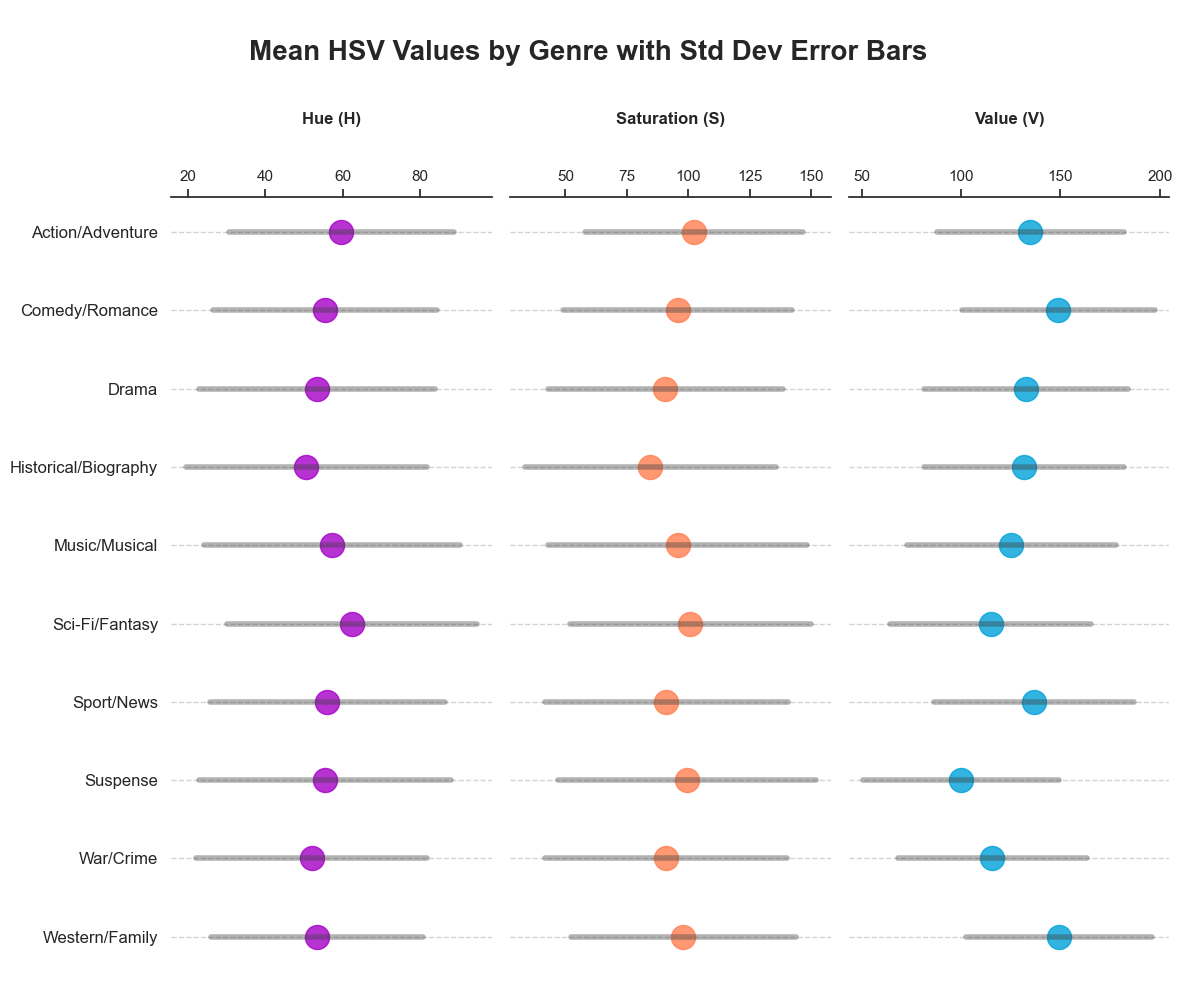

In [216]:
# Extract means and stds
means = avg_hsv_by_genre
stds = std_hsv_by_genre

genres = means.index.tolist()
y_pos = range(len(genres))

fig, axes = plt.subplots(1, 3, figsize=(12, 10), facecolor='none', sharey=True)

channels = ['mean_H', 'mean_S', 'mean_V']
titles = ['Hue (H)\n', 'Saturation (S)\n', 'Value (V)\n']

palette_1 = ['#0174A2', '#0784BA', '#00A1D8']
palette_2 = ['#A400C7', '#FF7F50', '#00A1D8']


for i, ax in enumerate(axes):

    # Set up the plot apparence
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.tick_top()

    # Set light gray grid lines
    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.grid(axis='x', visible=False) 
    
    channel = channels[i]

    for y, genre in enumerate(genres):
        mean = means.loc[genre, channel]
        std = stds.loc[genre, channel]

        # Plot error bar as a line with rounded caps
        ax.plot([mean - std, mean + std], [y, y], lw=4, color='#414142', alpha=0.4, solid_capstyle='round')

        # Plot mean point
        ax.scatter(
            mean, y,
            marker='o',
            color=palette_2[i],
            alpha=0.8,
            s=300
        )

    ax.set_title(titles[i], size=12, weight = 'semibold', pad=20)
    

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(genres, size=12)
axes[0].tick_params(axis='y')
axes[0].invert_yaxis()
fig.suptitle('\nMean HSV Values by Genre with Std Dev Error Bars \n', fontsize=20, fontweight='heavy')
plt.tight_layout()
plt.savefig('Plots/Mean HSV Values by Genre with Std Dev Error Bars.png', transparent=True)
plt.show()

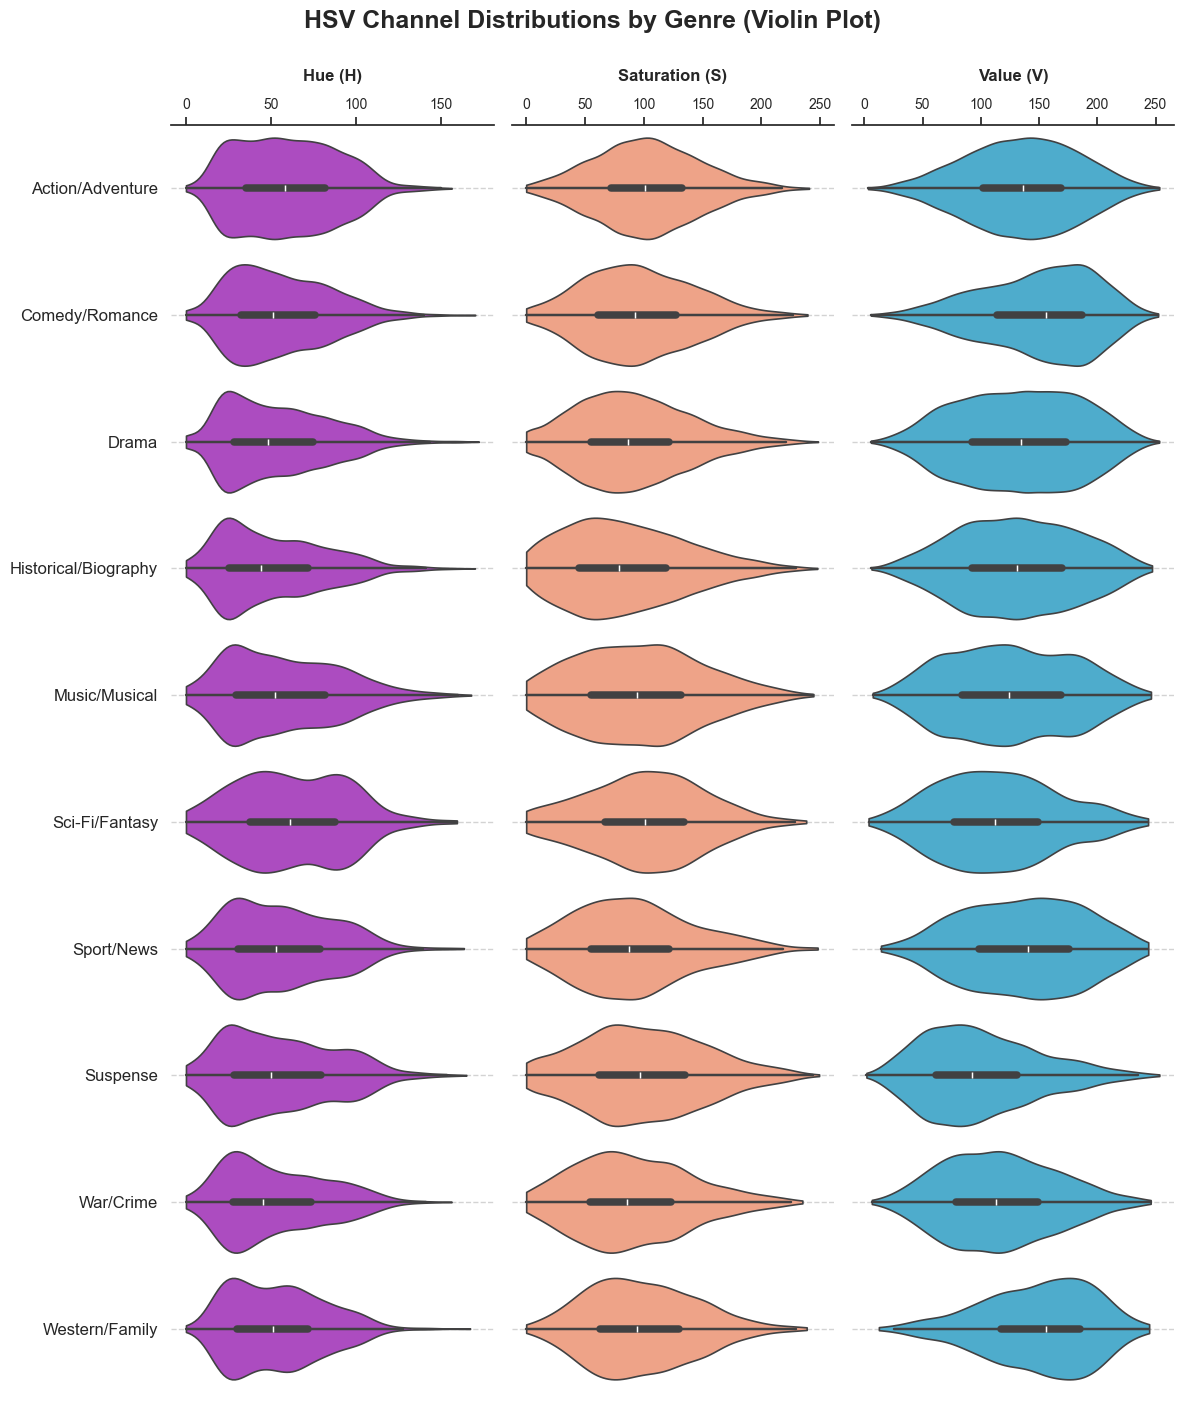

In [218]:

# Prepare data for violin plots
df_violin = df_features[['label', 'mean_H', 'mean_S', 'mean_V']].copy()
df_violin = df_violin.rename(columns={
    'mean_H': 'Hue (H)',
    'mean_S': 'Saturation (S)',
    'mean_V': 'Value (V)'
})

# Melt to long format
df_melted = df_violin.melt(id_vars='label', var_name='Channel', value_name='Value')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 14), sharey=True)

channels = ['Hue (H)', 'Saturation (S)', 'Value (V)']
palette = ['#B839D3', '#FF9B77', '#39B6E1']  

# Compute sorting order by average hue
genre_order = sorted(
    df_violin.groupby('label')["Hue (H)"]
    .mean()
    .index.tolist(), reverse=True
)

for i, channel in enumerate(channels):

    ax = axes[i]

    sns.violinplot(
        data=df_melted[df_melted['Channel'] == channel],
        y='label',
        x='Value',
        density_norm='width',
        order=genre_order,
        linewidth=1.2,
        cut=0,
        ax=ax,
        linecolor='#414142',
        color=palette[i]
    )


    ax.set_title(channel, fontsize=12, weight='semibold', pad=12)
    ax.spines[['bottom', 'right', 'left']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.grid(axis='x', visible=False) 

    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=12)


fig.suptitle('HSV Channel Distributions by Genre (Violin Plot)', fontsize=18, weight='bold', y=1)
plt.tight_layout()
plt.savefig('Plots/HSV Violin Plots by Genre.png', transparent=True)
plt.show()

**1.4.2 H, S, V histograms by movie genre**

In [24]:
def fix_and_parse_array(x):
    if isinstance(x, str):
        # Remove square brackets and replace spaces with commas
        fixed = re.sub(r'\s+', ',', x.strip("[]"))
        return np.fromstring(fixed, sep=',')
    return x  # if already a NumPy array

# Apply to all three histogram columns
df_features['hue_hist'] = df_features['hue_hist'].apply(fix_and_parse_array)
df_features['saturation_hist'] = df_features['saturation_hist'].apply(fix_and_parse_array)
df_features['value_hist'] = df_features['value_hist'].apply(fix_and_parse_array)

In [25]:
# Helper function to average lists of arrays
def average_histograms(hist_series):
    return np.mean(np.stack(hist_series.values), axis=0)

# Group and apply
avg_hue_by_genre = df_features.groupby('label')['hue_hist'].apply(average_histograms)
avg_sat_by_genre = df_features.groupby('label')['saturation_hist'].apply(average_histograms)
avg_val_by_genre = df_features.groupby('label')['value_hist'].apply(average_histograms)

In [26]:
# Turn each histogram series into long-form DataFrame
def melt_histograms(avg_hist_series, channel_name):
    data = []
    for genre, hist in avg_hist_series.items():
        for i, val in enumerate(hist):
            x = i / len(hist)  # Normalize to 0–1
            n_samples = int(val * 1000)  # Convert to sample density
            data.extend([(genre, channel_name, x)] * n_samples)
    return pd.DataFrame(data, columns=["Genre", "Channel", "Value"])

# Combine all three color channels
df_hue = melt_histograms(avg_hue_by_genre, "Hue")
df_sat = melt_histograms(avg_sat_by_genre, "Saturation")
df_val = melt_histograms(avg_val_by_genre, "Value")
df_all = pd.concat([df_hue, df_sat, df_val], ignore_index=True)

In [27]:
# Ensure consistent genre order
genre_order = sorted(avg_hue_by_genre.index.tolist(), reverse=False)
df_all["Genre"] = pd.Categorical(df_all["Genre"], categories=genre_order, ordered=True)


In [28]:
# Define color gradients
gradients = [['#A400C7', '#AE1CCD', '#B839D3', '#C255DA', '#CC71E0', '#D78EE6', '#E1AAEC', '#EBC6F3', '#F5E3F9', '#FFFFFF'],
             ['#FF7F50', '#FF8D63', '#FF9B77', '#FFAA8A', '#FFB89E', '#FFC6B1', '#FFD4C5', '#FFE3D8', '#FFF1EC', '#FFFFFF'],
             ['#00A1D8', '#1CABDC', '#39B6E1', '#55C0E5', '#71CBE9', '#8ED5EE', '#AAE0F2', '#C6EAF6', '#E3F5FB', '#FFFFFF']
            ]

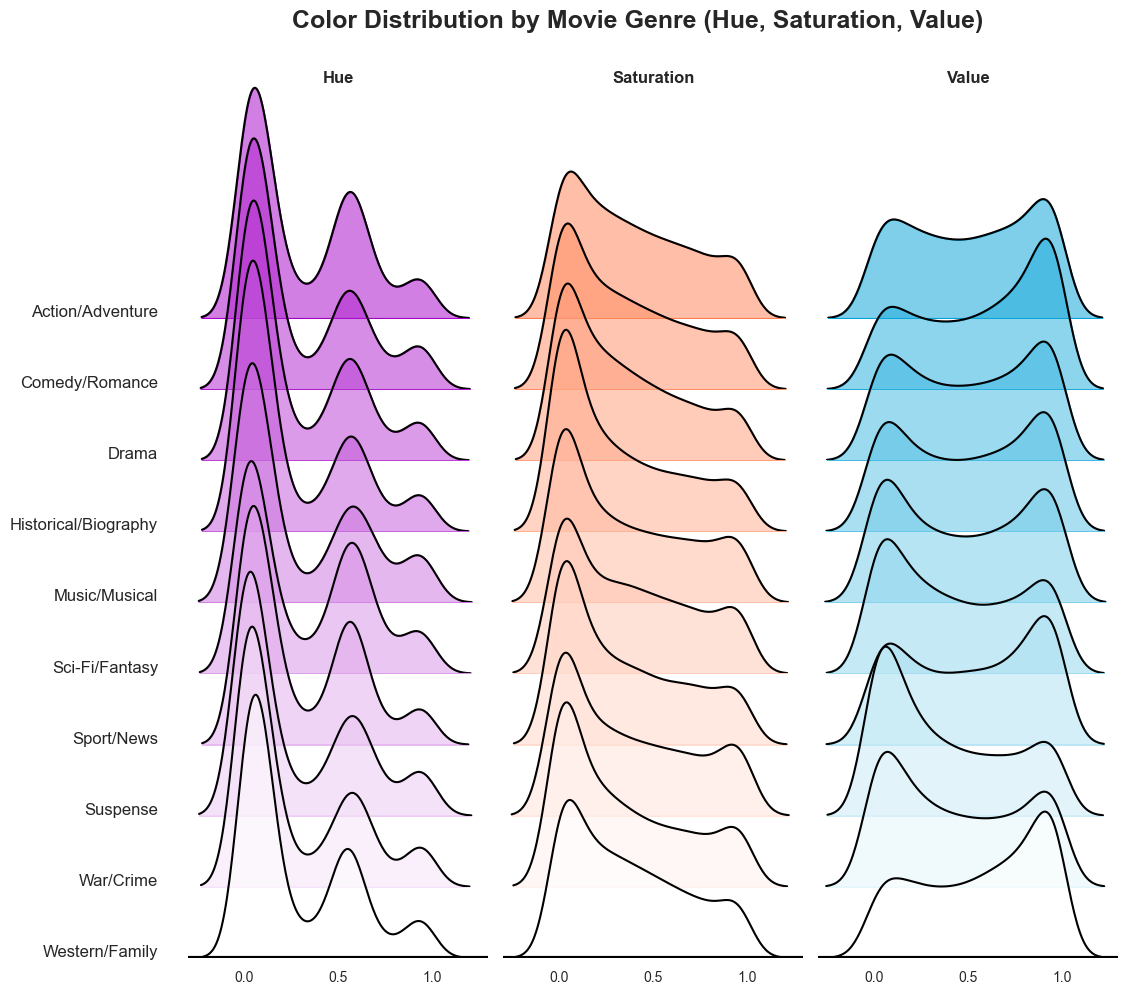

In [208]:
# Set up FacetGrid-like layout using subplots
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

fig, axes = plt.subplots(
    nrows=len(genre_order),
    ncols=3,
    figsize=(12, len(genre_order) * 1.2),
    sharey=True,
    sharex=True
)

channel_titles = ["Hue", "Saturation", "Value"]
channel_palette = ["#1f77b4", "#2ca02c", "#ff7f0e"]  # Optional: consistent channel colors

for j, channel in enumerate(channel_titles):
    for i, genre in enumerate(genre_order):
        ax = axes[i, j]
        subset = df_all[(df_all["Channel"] == channel) & (df_all["Genre"] == genre)]
        sns.kdeplot(
            data=subset,
            x="Value",
            fill=True,
            alpha=0.5,
            ax=ax,
            color=gradients[j][i]
        )
        sns.kdeplot(
            data=subset,
            x="Value",
            fill=False,
            ax=ax,
            color='black'
        )
        ax.set_xlim(-0.3, 1.3)
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_xlabel("")

        if j == 0:
            ax.text(-0.1, 0.02, genre, fontsize=12, va="center", ha="right", transform=ax.transAxes)

        if i == 0:
            ax.set_title(channel_titles[j], fontsize=12, weight='semibold', y=0.8)
            
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(axis='x', labelsize=10)
    ax.plot([-0.3, 1.3], [0, 0], lw=3, color='black')

# Final layout adjustments
plt.subplots_adjust(wspace=0.05, hspace=-0.75)
fig.suptitle( "Color Distribution by Movie Genre (Hue, Saturation, Value)", fontsize=18, weight='bold', y=0.9)
sns.despine(left=True, bottom=True)
plt.savefig('Plots/Color Distribution by Movie Genre (Hue, Saturation, Value).png', transparent=True)
plt.show()

**1.4.3 Posters with the highest/lowest feature values**

In [31]:
# check min and max values
max_value_row = df_features.loc[df_features['mean_V'].idxmax()]
max_value_row

tconst                                                    tt14926354
label                                                       Suspense
mean_H                                                           0.0
std_H                                                            0.0
skew_H                                                           NaN
mean_S                                                           0.0
std_S                                                            0.0
skew_S                                                           NaN
mean_V                                                    253.257508
std_V                                                       15.78637
skew_V                                                    -11.074816
hog_features                                 [0. 0. 0. ... 0. 0. 0.]
hsv_hist           [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0...
hue_hist           [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
saturation_hist    [1.0, 0.0, 0.0,

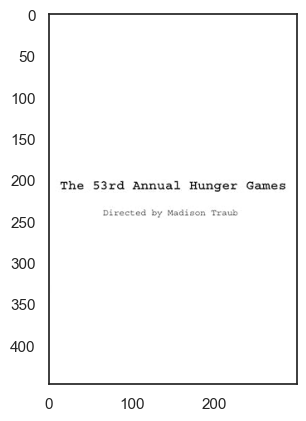

In [32]:
image_path = 'Data/WithText/tt14926354.jpg'
image = Image.open(image_path)
plt.imshow(image)

In [33]:
min_value_row = df_features.loc[df_features['mean_V'].idxmin()]
min_value_row

tconst                                                     tt2149532
label                                                       Suspense
mean_H                                                      2.008883
std_H                                                       7.648251
skew_H                                                      4.471142
mean_S                                                      8.594017
std_S                                                      39.887734
skew_S                                                      5.165182
mean_V                                                      1.798508
std_V                                                      14.745924
skew_V                                                     12.612335
hog_features                                 [0. 0. 0. ... 0. 0. 0.]
hsv_hist           [9.3192506e-01 5.3333334e-04 1.0666667e-03 2.5...
hue_hist           [0.93192506, 0.00053333334, 0.0010666667, 0.00...
saturation_hist    [0.93461663, 0.

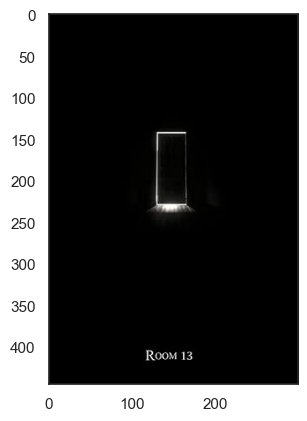

In [34]:
image_path = 'Data/WithText/tt2149532.jpg'
image = Image.open(image_path)
plt.imshow(image)

### **1.5 EDA of HOG Features**


In [44]:
hog_feature = pd.read_pickle("Features/classic_hog_features.pkl")
hog_feature = pd.DataFrame(hog_feature)
hog_feature.rename(columns={'filenames':'tconst'}, inplace=True)
hog_feature = hog_feature.merge(df_features[['tconst', 'label']], on='tconst', how='left')

In [46]:
hog_feature.head()

,tconst,features,label
0,tt0033467,"[0.3860245604710538, 0.3860245604710538, 0.172...",Suspense
1,tt0034583,"[0.765821656799104, 0.2775275800931298, 0.1877...",Comedy/Romance
2,tt0047396,"[0.3713225350436184, 0.18664679058790198, 0.37...",Suspense
3,tt0050083,"[0.47860224007478946, 0.2639377484445817, 0.11...",Drama
4,tt0052357,"[0.49486915842463414, 0.0681093314107548, 0.10...",Suspense


In [48]:
# Convert list of lists into 2D NumPy array
hog_matrix = np.stack(hog_feature['features'].values)

# Turn into a DataFrame with labeled genres
hog_df = pd.DataFrame(hog_matrix)
hog_df['Genre'] = hog_feature['label']

**1.5.1 Violin Plots (Selected HOG Features by Genre)**  


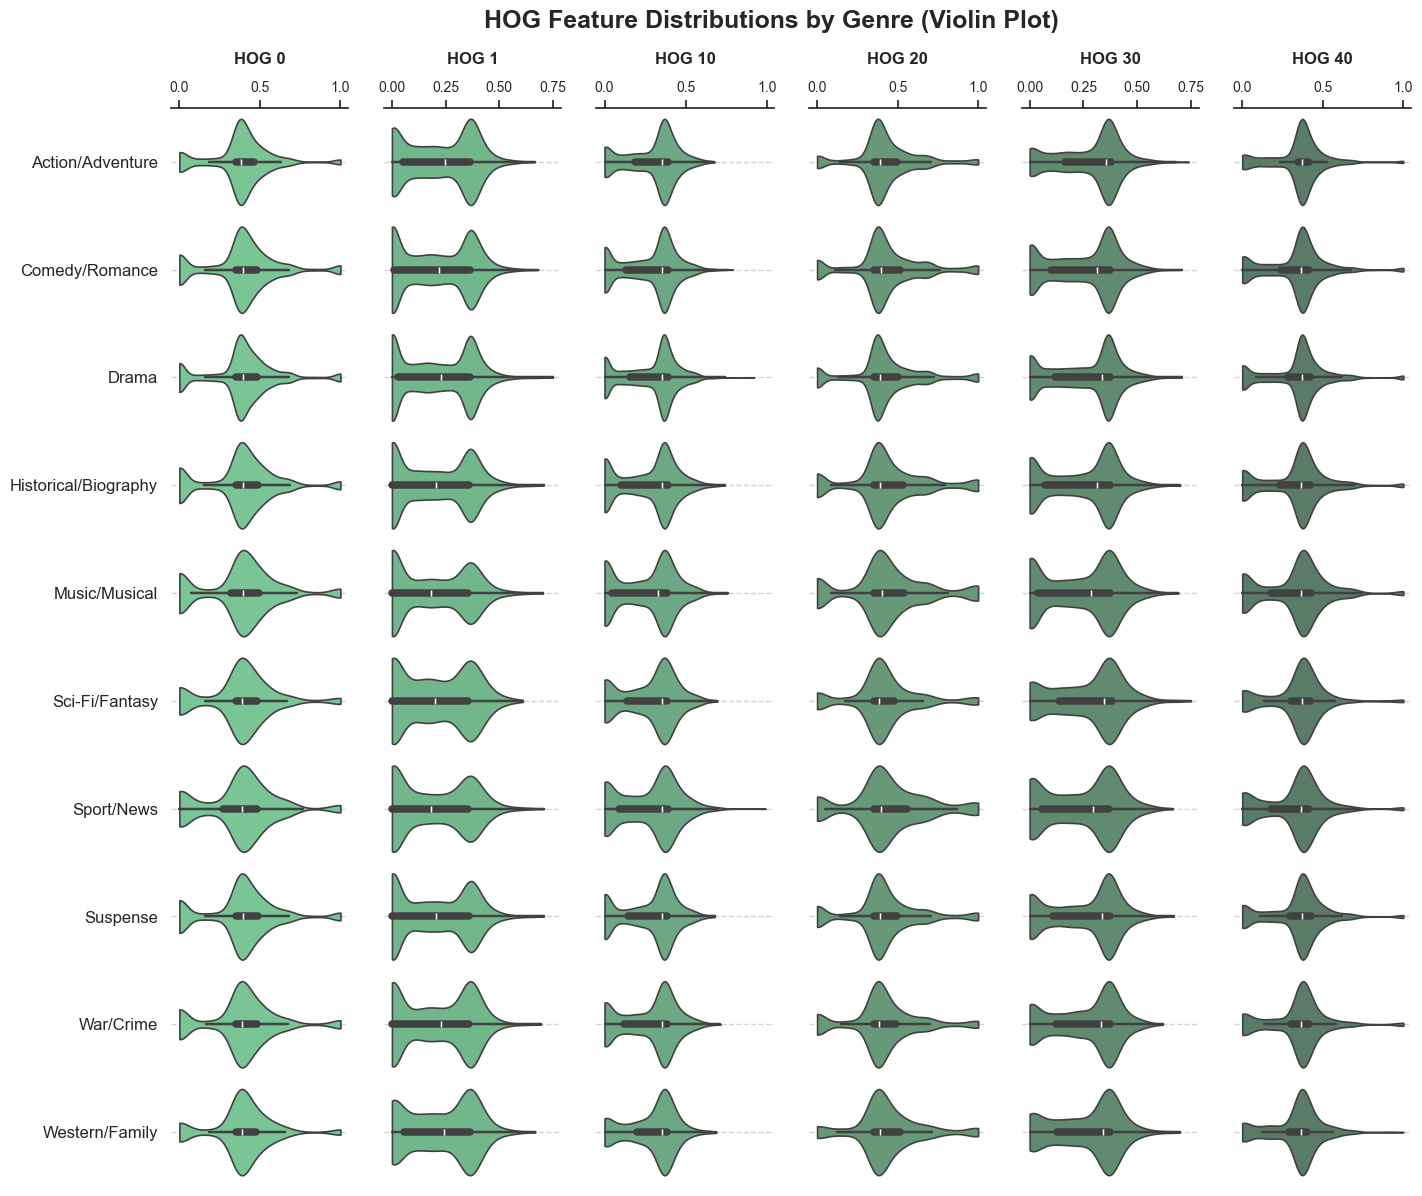

In [220]:

# Step 1: Prepare data
selected_features = [0, 1, 10, 20, 30, 40]
hog_melted = hog_df.melt(id_vars='Genre', value_vars=selected_features,
                         var_name='HOG Feature', value_name='Value')

# Step 2: Rename HOG Feature labels to be more readable
feature_labels = {i: f'HOG {i}' for i in selected_features}
hog_melted['HOG Feature'] = hog_melted['HOG Feature'].astype(int).map(feature_labels)



# Step3: Plot

palette = [
"#6CD292",
"#67C289",
"#62B280",
"#5EA277",
"#59926E",
"#548166",
"#4F715D",
"#4B6154",
"#46514B",
"#414142"
]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

fig, axes = plt.subplots(1, 6, figsize=(16, 14), sharey=True)

channels = ['HOG 0', 'HOG 1', 'HOG 10', 'HOG 20', 'HOG 30', 'HOG 40']

# Compute sorting order by average hue
genre_order = sorted(
    df_violin.groupby('label')["Hue (H)"]
    .mean()
    .index.tolist(), reverse=True
)

for i, channel in enumerate(channels):
    ax = axes[i]

    sns.violinplot(
        data=hog_melted[hog_melted['HOG Feature'] == channel],
        y='Genre',
        x='Value',
        density_norm='width',
        order=genre_order,
        linewidth=1.2,
        cut=0,
        ax=ax,
        linecolor='#414142',
        color = palette[i]
    )


    ax.set_title(channel, fontsize=12, weight='semibold', pad=12)
    ax.spines[['bottom', 'right', 'left']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.invert_yaxis()
    ax.grid(axis='y', color='lightgray', linestyle='--')
    ax.grid(axis='x', visible=False) 

    ax.xaxis.tick_top()
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=12)


fig.suptitle('HOG Feature Distributions by Genre (Violin Plot)', fontsize=18, weight='bold', y=0.95)
# plt.tight_layout()
plt.savefig('Plots/HOG Violin Plots by Genre.png', transparent=True)
plt.show()

**1.5.2 Correlation Heatmap (Top N Features)**

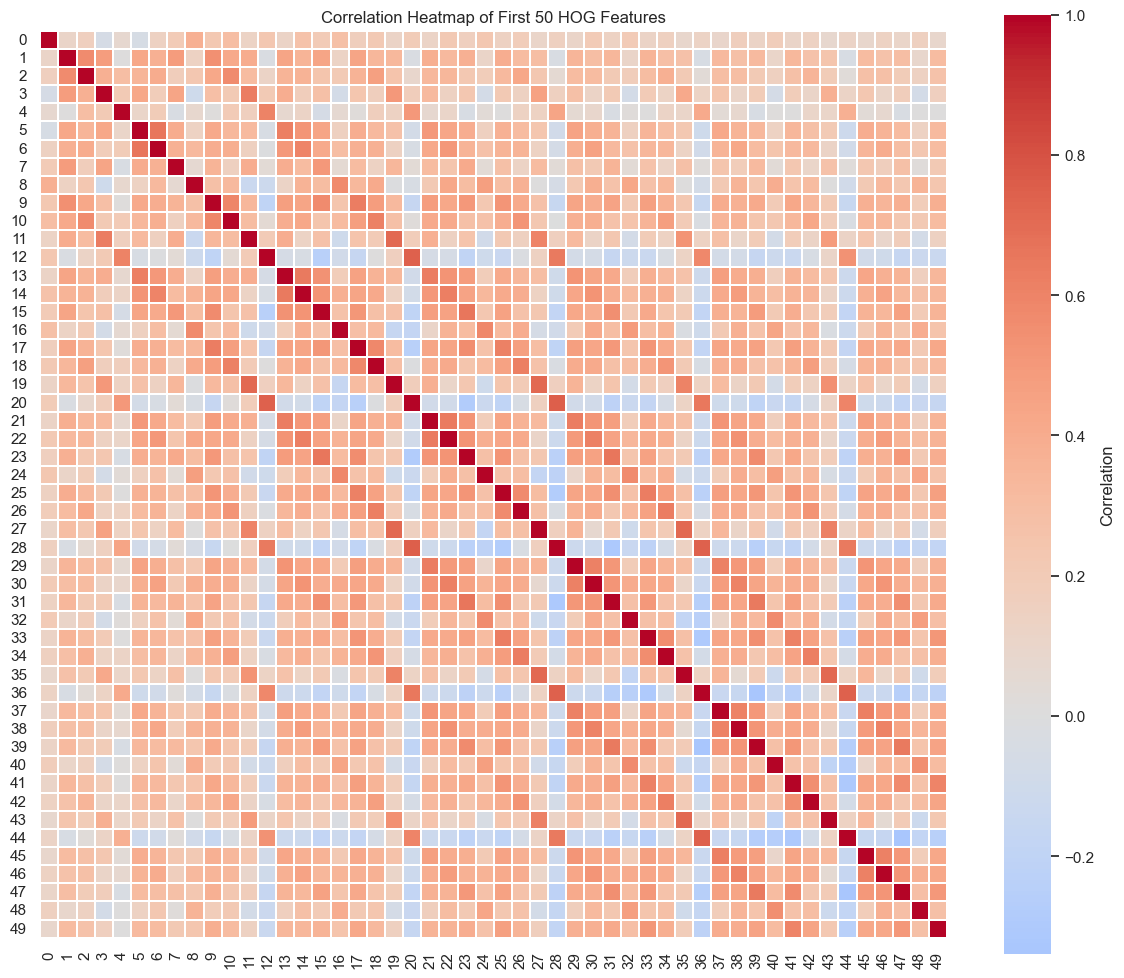

In [52]:
# Choose number of features to show
n_features = 50
corr_matrix = np.corrcoef(hog_matrix.T[:n_features])

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    xticklabels=range(n_features),
    yticklabels=range(n_features),
    square=True,
    linewidths=0.1,
    cbar_kws={'label': 'Correlation'}
)
plt.title(f'Correlation Heatmap of First {n_features} HOG Features')
plt.tight_layout()
plt.show()

**1.5.3 t-SNE Plot**

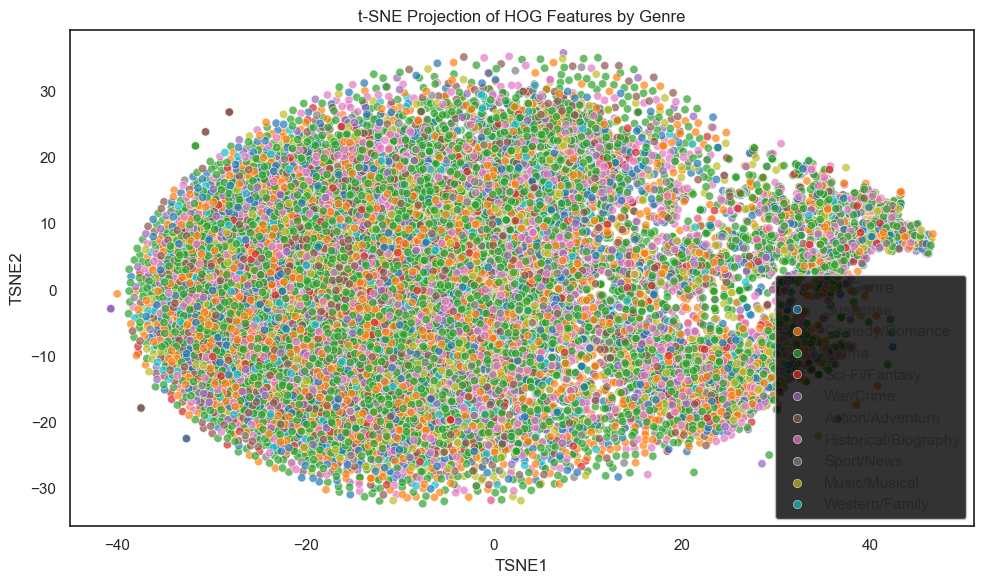

In [54]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
hog_tsne = tsne.fit_transform(hog_matrix)

df_tsne = pd.DataFrame({
    'TSNE1': hog_tsne[:, 0],
    'TSNE2': hog_tsne[:, 1],
    'Genre': hog_feature['label']
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Genre', palette='tab10', alpha=0.7)
plt.title('t-SNE Projection of HOG Features by Genre')
plt.tight_layout()
plt.show()

**1.5.4 Histogram of Mean HOG Feature Values by Genre**

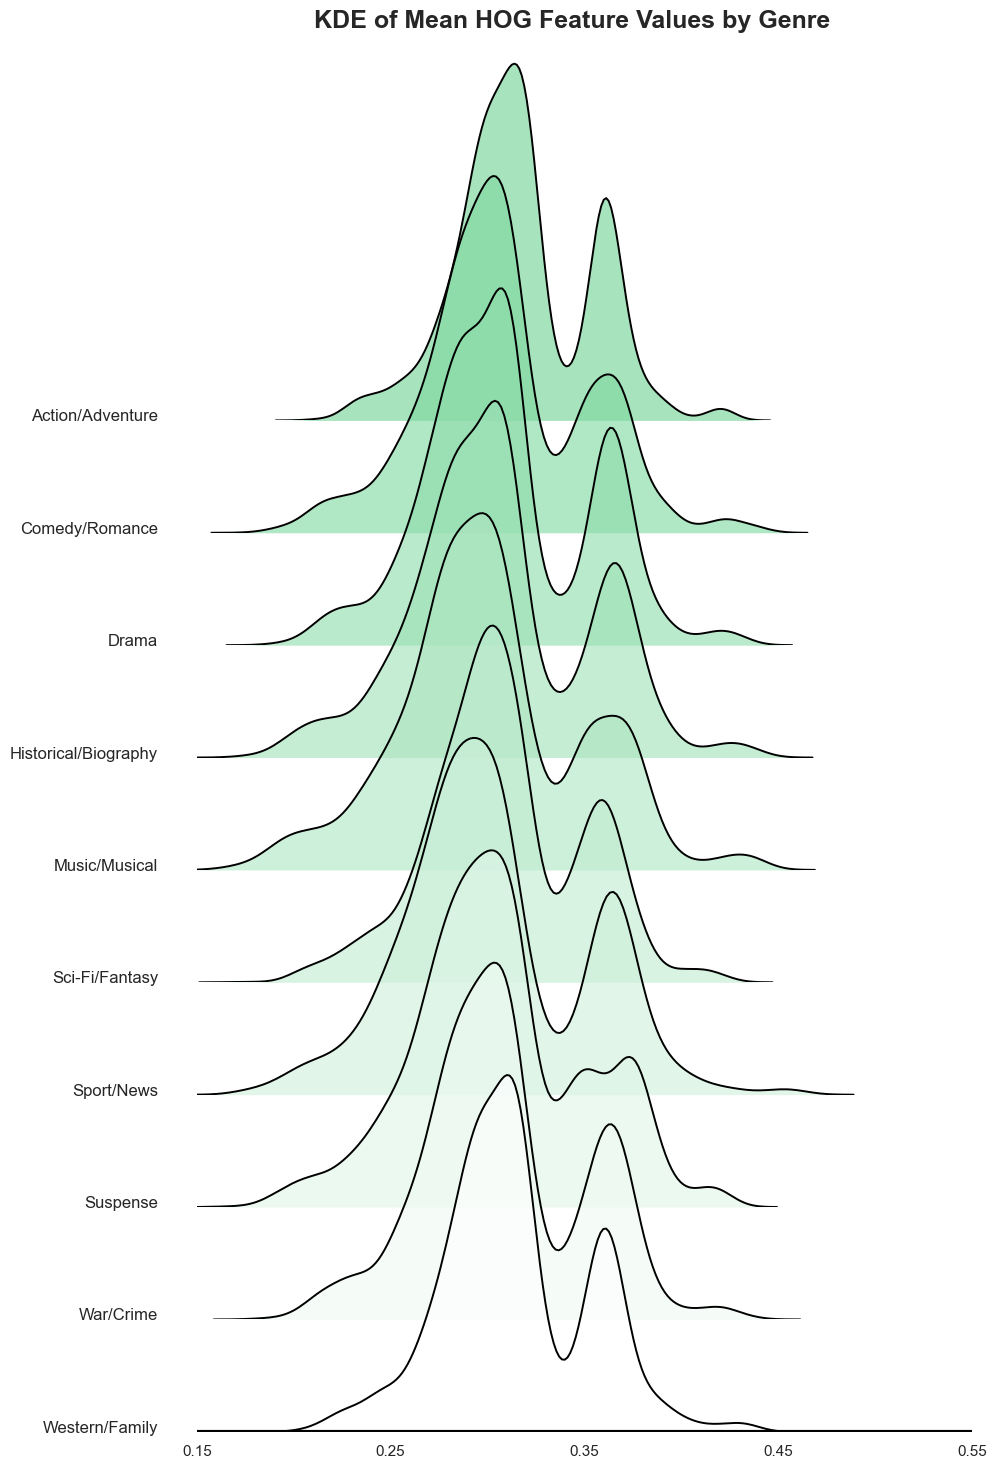

In [262]:
# Optional: sort genres
mean_profiles = hog_df.groupby('Genre').mean()
genre_order = mean_profiles.index.tolist()
palette = ['#6CD292', '#7CD79E', '#8DDCAA', '#9DE1B6', '#ADE6C2', '#BEEBCF', '#CEF0DB', '#DEF5E7','#EFFAF3', '#FFFFFF']

# Set up subplots
fig, axes = plt.subplots(
    nrows=len(genre_order),
    ncols=1,
    figsize=(10, 1.8 * len(genre_order)),
    sharex=True
)

# Plot a histogram of mean HOG values for each genre
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

for i, genre in enumerate(genre_order):
    ax = axes[i]

    values = mean_profiles.loc[genre].values

    sns.kdeplot(
        x=values,
        fill=True,
        alpha=0.6,
        linewidth=0,
        ax=ax,
        color=palette[i]
    )

    # Outline for contrast
    sns.kdeplot(
        x=values,
        fill=False,
        linewidth=1.4,
        ax=ax,
        color='black'
    )

    ax.set_xlim(0.15, 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Genre label on the left
    ax.text(-0.05, 0.01, genre, fontsize=12, va="center", ha="right", transform=ax.transAxes)

# Final adjustments
axes[-1].set_xticks([0.15, 0.25, 0.35, 0.45, 0.55])
ax.plot([0.15, 0.55], [0, 0], lw=3, color='black')
axes[-1].set_xlabel("Mean HOG Feature Value")

plt.subplots_adjust(hspace=-0.7)
fig.suptitle("KDE of Mean HOG Feature Values by Genre", fontsize=18, weight='bold', y=0.9)
sns.despine(left=True, bottom=True)

plt.savefig("Plots/HOG Mean Feature KDE by Genre.png", transparent=True)
plt.show()

## **Section 2: Advanced Feature Extraction**

This section uses advanced deep learning techniques to extract high-level features from the movie posters.

### Methods included:

- **Pretrained CNN (ResNet50)**: Use a pretrained ResNet50 model to obtain feature embeddings.
- **Vision Transformers (ViT)**: Extract image embeddings using a Vision Transformer model.
- **Custom CNN Architecture**: A skeleton of a shallow custom CNN is provided as a template for domain-specific feature extraction.

Each advanced method extracts features which are saved separately for further analysis and model development.

In [55]:
# Import libraries for advanced feature extraction
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from transformers import ViTFeatureExtractor, ViTModel

In [56]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


### **2.1 Pretrained CNN (ResNet50)**

In [57]:
# # Load pretrained ResNet50 model
# resnet50 = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)

# # Remove the final classification layer to obtain feature embeddings
# feature_extractor = torch.nn.Sequential(*list(resnet50.children())[:-1])
# feature_extractor.to(device)
# feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [58]:
# # Define the transformation pipeline to preprocess images for ResNet50
# transform_pipeline = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [59]:
# def extract_resnet50_features(image_path):
#     """
#     Extract feature embeddings from an image using ResNet50.
    
#     Args:
#         image_path (str): Path to the input image file.
#     Returns:
#         features (numpy.array): Flattened feature embedding vector.
#     """
#     image = Image.open(image_path).convert('RGB')
#     image = transform_pipeline(image).unsqueeze(0).to(device)
#     with torch.no_grad():
#         features = feature_extractor(image)
#     return features.cpu().numpy().flatten()

In [76]:
# # Lists to store advanced features and filenames
# resnet_features = []
# resnet_filenames = []
# labels = []

# # Extract features from each image using ResNet50
# for filename in df['tconst']:
#     label = np.array(df[df['tconst'] == filename]['reduced_genre'])
#     img_path = os.path.join(image_dir, filename + '.jpg')
#     try:
#         features_resnet = extract_resnet50_features(img_path)
#     except Exception as e:
#         print(f"Error processing {filename}: {e}")
#         continue
#     resnet_features.append(features_resnet)
#     resnet_filenames.append(filename)
#     labels.append(label)

In [78]:
# # Save the advanced features extracted via ResNet50
# with open('Features/resnet_features.pkl', 'wb') as f:
#     pickle.dump({'filenames': resnet_filenames, 'features': resnet_features}, f)

# print('Advanced features extracted and saved successfully using ResNet50!')

Advanced features extracted and saved successfully using ResNet50!


In [96]:
# tconst = np.array(resnet_filenames, dtype='object').reshape(-1, 1)
# table_features = np.concatenate((tconst, labels), axis = 1)
# df_features = pd.DataFrame(table_features)

# # Number of fixed columns (label + HSV moments) is 10.
# fixed_columns = [
#     'tconst',
#     'label'
# ]

# df_features.columns = fixed_columns
# df_features['resnet_features'] = list(resnet_features)


In [102]:
# df_features.to_csv("Features/Resnet_features.csv")

In [104]:
df_resnet_features = pd.read_csv("Features/Resnet_features.csv")

### **2.2 Vision Transformers (ViT)**

Here we extract image embeddings using a Vision Transformer. The process is similar to the ResNet50 extraction but uses a transformer-based architecture.

The [CLS] token representation from the last hidden state is used as the feature vector.

In [106]:
# # Load pretrained ViT model and corresponding feature extractor
# vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
# vit_model.to(device)
# vit_model.eval()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/miniconda3/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [108]:
# def extract_vit_features(image_path):
#     """
#     Extract features from an image using a Vision Transformer (ViT).
    
#     Args:
#         image_path (str): Path to the image file.
#     Returns:
#         features (numpy.array): Flattened feature embedding vector from ViT.
#     """
#     image = Image.open(image_path).convert('RGB')
#     inputs = vit_feature_extractor(images=image, return_tensors="pt")
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = vit_model(**inputs)
#     # Extract the embedding corresponding to the [CLS] token
#     cls_features = outputs.last_hidden_state[:, 0, :]
#     return cls_features.cpu().numpy().flatten()

In [110]:
# # Lists for storing ViT features and filenames
# vit_features = []
# vit_filenames = []
# labels = []

In [112]:
# # Extract ViT features from images
# for filename in df['tconst']:

#     label = np.array(df[df['tconst'] == filename]['reduced_genre'])
    
#     img_path = os.path.join(image_dir, filename + '.jpg')
#     try:
#         feat_vit = extract_vit_features(img_path)
#     except Exception as e:
#         print(f"Error processing {filename} with ViT: {e}")
#         continue
#     vit_features.append(feat_vit)
#     vit_filenames.append(filename)
#     labels.append(label)

In [114]:
# # Save the ViT features
# with open('Features/vit_features.pkl', 'wb') as f:
#     pickle.dump({'filenames': vit_filenames, 'features': vit_features}, f)

# print('Advanced features extracted and saved successfully using ViT!')

Advanced features extracted and saved successfully using ViT!


In [116]:
# tconst = np.array(vit_filenames, dtype='object').reshape(-1, 1)
# table_features = np.concatenate((tconst, labels), axis = 1)
# df_features = pd.DataFrame(table_features)

# fixed_columns = [
#     'tconst',
#     'label'
# ]

# df_features.columns = fixed_columns
# df_features['vit_features'] = list(vit_features)

In [118]:
# df_features.to_csv("Features/ViT_features.csv")

In [120]:
df_vit_features = pd.read_csv("Features/ViT_features.csv")

### **2.3 Custom CNN Skeleton for Feature Extraction**

Below is a skeleton for a custom CNN architecture. This model can be expanded and trained on the dataset to extract domain-specific features. 

The architecture includes several convolutional layers followed by fully connected layers. Adjust the network dimensions and training parameters based on experimental results.

In [122]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            # Adjust the input dimension to match the flattened output size
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.classifier(x)
        return x

In [124]:
# Instantiate the custom CNN
model = CustomCNN(num_classes=10)
print(model)

# Define loss function and optimizer (example setup)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100352, out_features=256, bias=Tr